In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# Load the dataframe
df = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv', delimiter=',')
df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,06/15/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,30.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
1,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,11/25/2014,Violations were cited in the following area(s).,20F,Current letter grade card not posted.,Not Critical,NaN,NaN,NaN,08/28/2017,Administrative Miscellaneous / Initial Inspection
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106.0,3478134702,Italian,10/03/2016,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,2.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
3,50061389,TACK'S CHINESE TAKE OUT,STATEN ISLAND,11C,HOLDEN BLVD,10314.0,7189839854,Chinese,05/17/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,46.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
4,41516263,NO QUARTER,BROOKLYN,8015,5 AVENUE,11209.0,7187019180,American,03/30/2017,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,18.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection


In [3]:
# Find percentage of null values
for item in df.columns:
    print(item, df[item].isna().sum())

CAMIS 0
DBA 359
BORO 0
BUILDING 109
STREET 9
ZIPCODE 9
PHONE 5
CUISINE DESCRIPTION 0
INSPECTION DATE 0
ACTION 1135
VIOLATION CODE 6504
VIOLATION DESCRIPTION 6979
CRITICAL FLAG 0
SCORE 23214
GRADE 204505
GRADE DATE 207098
RECORD DATE 0
INSPECTION TYPE 1135


In [4]:
# List the types of restaurants
out_file = 'Cuis_Descr.txt'
cuisine = []
cuisine = df.loc[:,'CUISINE DESCRIPTION'].dropna()
with open(out_file,'w') as file:
    [file.write(item + '\n') for item in cuisine.unique()]

In [62]:
df1 = df.groupby('CUISINE DESCRIPTION').count()['CAMIS']
df1.sort_values(ascending=False)

CUISINE DESCRIPTION
American                                                            90968
Chinese                                                             42321
Latin (Cuban, Dominican, Puerto Rican, South & Central American)    19135
Pizza                                                               18754
Italian                                                             17732
CafÃ©/Coffee/Tea                                                    15568
Mexican                                                             15217
Japanese                                                            14491
Caribbean                                                           13021
Bakery                                                              11948
Spanish                                                             11695
Pizza/Italian                                                        8728
Asian                                                                6255
Delicatessen      

# TO DO
Divide the restaurants based on types (perhaps focus on most common ones?)

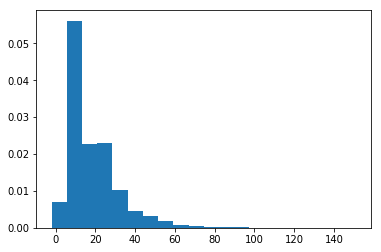

In [5]:
# Plot the distribution of scores
scores = df.loc[:,'SCORE'].dropna()
plt.hist(scores, density=True, bins=20)
plt.show()

In [6]:
scores.describe()

count    376704.000000
mean         18.910181
std          12.958955
min          -2.000000
25%          11.000000
50%          15.000000
75%          24.000000
max         151.000000
Name: SCORE, dtype: float64

In [7]:
# Open the file with the violations
in_file = 'Violations_explanation.csv'
viol_codes = {}
with open(in_file, 'r') as f_in:
    f_in.readline() # Skip the header
    for line in f_in.readlines():
        line = line.strip('\n')
        line = line.split(';')
        viol_codes[line[0]] = line[-1]
        
codes = df['VIOLATION CODE'].map(viol_codes)
df.insert(10, 'VIOLATION TYPE', codes)
#df.head()

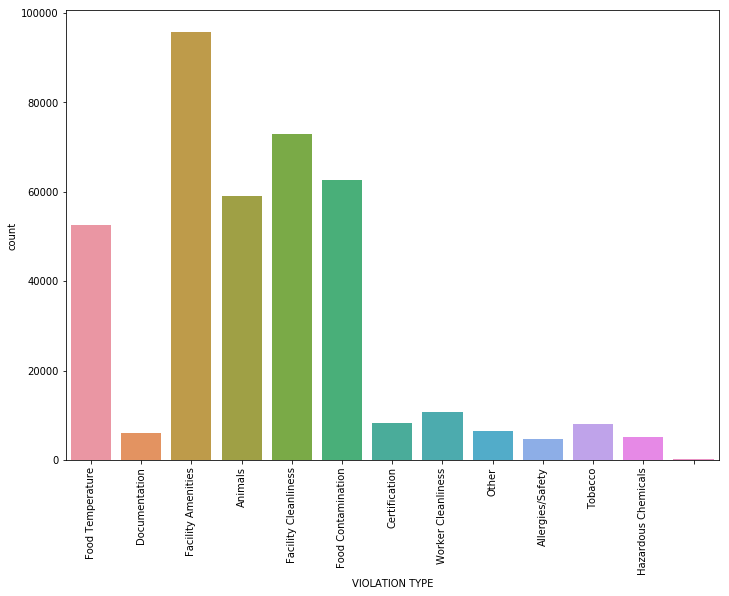

<Figure size 432x288 with 0 Axes>

In [11]:
# Plot the frequencies of violations
fig, ax = plt.subplots(figsize=(11.7, 8.27))
figure = sns.countplot(df['VIOLATION TYPE'], ax=ax)
figure.set_xticklabels(figure.get_xticklabels(),rotation=90)
_ = plt.figure()

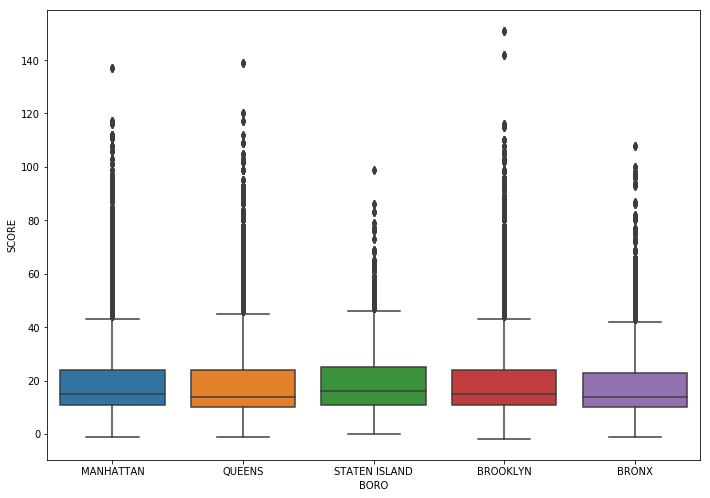

In [13]:
# Group by borough
df1 = df.loc[:,['BORO','SCORE']].dropna()
boros = df1.groupby(['BORO'])
boros.describe()
fig, ax = plt.subplots(figsize=(11.7, 8.27))
_ = sns.boxplot(df1['BORO'], df1['SCORE'], ax=ax)

In [21]:
critical = df.loc[:,['CRITICAL FLAG', 'SCORE', 'GRADE', 'RECORD DATE', 'INSPECTION TYPE']].dropna()

In [30]:
Y = critical.iloc[:,0]
X = critical.iloc[:,1:]
from sklearn.model_selection import train_test_split
from sklearn import tree

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
estimator = tree.DecisionTreeClassifier(criterion='entropy')
estimator.fit(X_train, Y_train)
Y_train = Y_train.iloc[:,0].values
Y_test = Y_test.iloc[:,0].values

ValueError: could not convert string to float: 'Cycle Inspection / Initial Inspection'